<a href="https://colab.research.google.com/github/Abhiroop2004/CV-Regional-Secret-Image-Sharing/blob/main/Number_Plate_Detection_Training_Insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision in Secret Sharing
### A Hackathon Submission for **INSIGHT**

- Team Name -  `WatchTower`
- Leader Name - `Abhiroop Sarkar`
- Track - `Safety and Security`


### Connecting Google Drive to load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Image Instance Segmentation using Mask-RCNN

### Importing Libraries

In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### Custom Dataset Training

Defining the functions

In [3]:
import xml.etree.ElementTree as ET

class CustomDataset(Dataset):
    def __init__(self, img_dir, annot_dir, transforms=None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(img_dir))  # Sort the images

    def parse_voc_xml(self, filename):
        tree = ET.parse(filename)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)

        #print(boxes, labels, "\n")
        return boxes, labels

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        #print(f"Loading image: {img_filename}")
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        # Load and parse annotation
        annot_filename = img_filename.replace('.png', '.xml')
        #print(f"Loading annotation: {annot_filename}")
        annot_path = os.path.join(self.annot_dir, annot_filename)
        boxes, labels = self.parse_voc_xml(annot_path)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Dummy masks, as we don't have real ones
        masks = torch.ones((len(boxes), img.size[1], img.size[0]), dtype=torch.uint8)

        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
def evaluate(model, data_loader, device):
    model.eval()
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_masks = output['masks'].cpu().numpy()

                true_boxes = targets[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()

                iou = calculate_mean_iou(pred_boxes, true_boxes)
                total_iou += iou
                count += 1

        # Print or log the average IoU over the dataset
        print(f"Average IoU: {total_iou / count:.4f}")

# Example IoU calculation function
def calculate_mean_iou(pred_boxes, true_boxes, threshold=0.5):
    def iou(boxA, boxB):
        # Compute intersection area
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # Compute union area
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        unionArea = float(boxAArea + boxBArea - interArea)

        return interArea / unionArea
    ious = []
    for pred_box in pred_boxes:
        for true_box in true_boxes:
            ious.append(iou(pred_box, true_box))

    ious = [i for i in ious if i >= threshold]
    return np.mean(ious) if ious else 0.0

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_model():
    dataset = CustomDataset(img_dir=r'/content/drive/MyDrive/Data/images', annot_dir=r'/content/drive/MyDrive/Data/annotations', transforms=get_transform(train=True))
    dataset_test = CustomDataset(img_dir=r'/content/drive/MyDrive/Data/images', annot_dir=r'/content/drive/MyDrive/Data/annotations', transforms=get_transform(train=False))

    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-40])
    print(f"Train Indices:{indices[:-40]}")
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
    print(f"Test Indices:{indices[-40:]}")

    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
    print ("Train dataset loaded!")
    data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print ("Test dataset loaded!")

    num_classes = 2

    model = get_model(num_classes)
    device = torch.device('cuda')
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    num_epochs = 10
    print("Training!")
    for epoch in range(num_epochs):
        print(f"Iteration {epoch+1}...")
        # Train for one epoch
        model.train()
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Update the learning rate
        lr_scheduler.step()
    print ("Training Complete")
    evaluate(model, data_loader_test, device=device)
    return model


Training the Model

In [6]:
custom_model = train_model()

Train Indices:[336, 333, 61, 302, 84, 91, 281, 152, 44, 222, 328, 419, 351, 129, 382, 169, 247, 65, 326, 401, 36, 88, 332, 34, 372, 214, 144, 46, 45, 172, 137, 13, 396, 254, 96, 403, 154, 53, 283, 103, 265, 150, 362, 138, 414, 219, 145, 7, 397, 377, 177, 166, 358, 209, 116, 42, 9, 228, 229, 165, 263, 82, 112, 322, 37, 272, 113, 371, 227, 273, 67, 192, 194, 308, 390, 30, 249, 370, 41, 27, 26, 43, 241, 287, 271, 252, 49, 130, 143, 355, 68, 217, 394, 215, 110, 236, 199, 183, 94, 234, 10, 352, 100, 18, 159, 50, 314, 58, 315, 93, 216, 213, 115, 136, 74, 128, 347, 340, 208, 71, 119, 90, 114, 311, 131, 320, 305, 290, 17, 16, 5, 353, 289, 298, 75, 193, 405, 359, 218, 80, 83, 301, 413, 369, 345, 11, 408, 162, 28, 175, 35, 201, 275, 89, 279, 186, 295, 258, 198, 387, 126, 231, 226, 348, 122, 173, 205, 24, 284, 179, 415, 223, 111, 153, 206, 72, 135, 251, 429, 341, 210, 303, 262, 3, 178, 325, 32, 260, 411, 407, 158, 87, 293, 409, 133, 160, 343, 384, 95, 19, 184, 266, 76, 62, 346, 250, 54, 248, 52, 

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 81.8MB/s]


Training!
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Training Complete
Average IoU: 0.7507


### Example Prediction

In [13]:
def predict_and_visualize(model, image_path, device, score_threshold=0.5):
    transform = T.Compose([T.ToTensor(), ])
    image = transform(Image.open(image_path).convert("RGB"))
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    masks = prediction[0]['masks'].cpu().numpy()  # (N, 1, H, W)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    #print(scores, "\n", masks)

    if len(boxes) == 0:
        print("No predictions were made for this image.")
        return

    plt.imshow(Image.open(image_path).convert("RGB"))

    for i in range(len(boxes)):
        if scores[i] > score_threshold:
            mask = masks[i, 0]
            plt.contour(mask, colors='r', linewidths=2)  # Mask contour

            box = boxes[i]
            print(f"Box = {box}")
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='blue', fill=False, linewidth=2))  # Bounding box
            plt.text(box[0], box[1] - 10, f'{i+1}', color='yellow', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))  # Text label
    plt.show()

Prediction a Dataset Test Image

Box = [ 92.58204 116.85099 281.09634 157.0364 ]


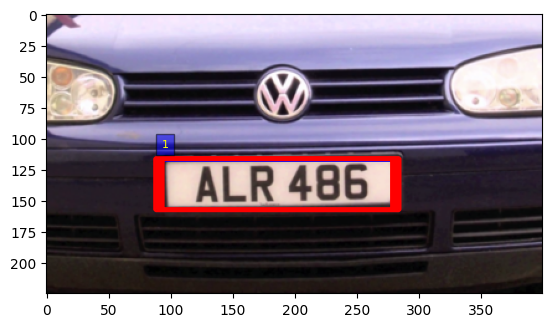

In [16]:
predict_and_visualize(custom_model, "Cars48.png", device=torch.device('cuda'))

Prediction on a Random Image from Pixabay (lowered threshold for detecting multiple number plates)

Box = [564.90735 717.961   644.7146  742.4431 ]
Box = [223.2497  725.50726 273.1359  745.3912 ]
Box = [556.02484 713.144   666.83606 750.2711 ]
Box = [ 81.72038 236.56363 215.67664 292.1791 ]
Box = [213.49207 720.5667  295.4887  749.85016]
Box = [546.60486 708.80536 721.06396 761.24866]
Box = [ 77.40622 246.14436 165.85127 275.35794]
Box = [391.58142 532.5807  454.177   557.42206]
Box = [936.9405  461.52524 993.1797  482.68643]


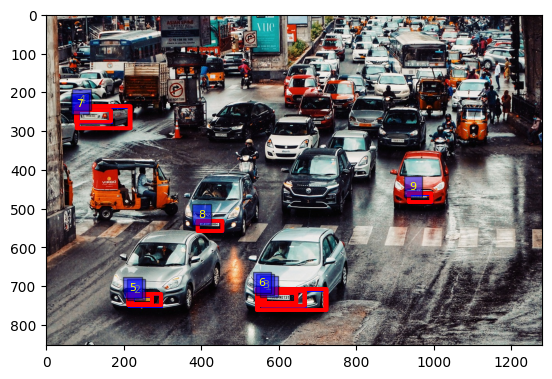

In [21]:
predict_and_visualize(custom_model, "/content/traffic-7272520_1280.jpg", device=torch.device('cuda'), score_threshold=0.12)

### Export the model

In [23]:
file_name = "Number_Plate_Model.pt"
torch.save(custom_model.state_dict(), file_name)